**Objective**: 
Create new features from the cleaned Silver table to support trend analysis and potential machine learning tasks.

**Input**:  (Silver Delta table)  
**Output**: (Gold Delta table)

**Tools**: 
- PySpark
- Window functions
- Built-in SQL functions (`lag`, `avg`, `round`, etc.)
- pyspark.sql.window for rolling and lagging logic
- Pandas & Matplotlib for visual validation



In [0]:
df_silver = spark.table("bitcoin.market_data.silver_bitcoin")

from pyspark.sql.functions import col, lag, round, avg
from pyspark.sql.window import Window

# Define a window ordered by date
window_spec = Window.orderBy("market_date")

# Create new features
# For each day, what was the closing price yesterday?
# How much (in %) did the price go up or down compared to yesterday?
# What was the average closing price over the past 7 days (including today)
df_features = df_silver \
    .withColumn("prev_close", lag("close").over(window_spec)) \
    .withColumn("daily_change_pct", round(((col("close") - col("prev_close")) / col("prev_close")) * 100, 2)) \
    .withColumn("rolling_avg_close_7d", round(avg("close").over(window_spec.rowsBetween(-6, 0)), 2))


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


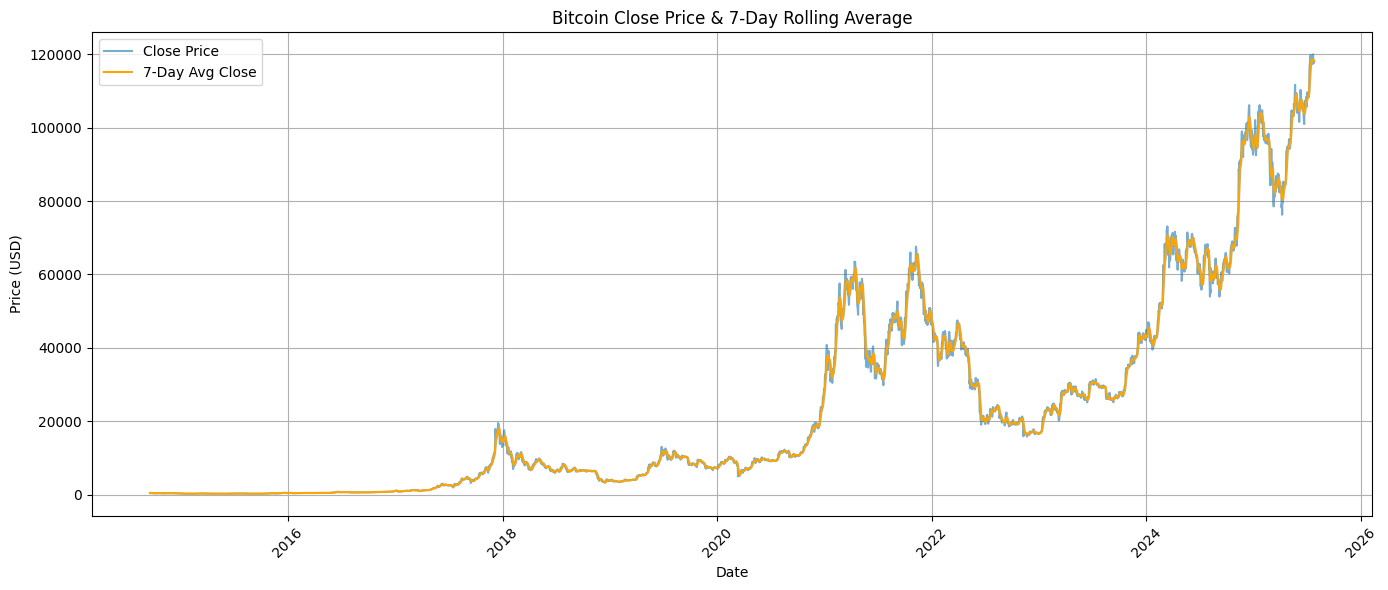

In [0]:
# Convert to pandas
df_plot = df_features.select("market_date", "close", "daily_change_pct", "rolling_avg_close_7d") \
                     .orderBy("market_date").dropna().toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(df_plot["market_date"], df_plot["close"], label="Close Price", alpha=0.6)
plt.plot(df_plot["market_date"], df_plot["rolling_avg_close_7d"], label="7-Day Avg Close", color='orange')

plt.title("Bitcoin Close Price & 7-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.grid(True)

plt.show()


In [0]:
df_features.write.format("delta") \
    .mode("overwrite") \
    .saveAsTable("bitcoin.market_data.features_bitcoin")

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
